In [ ]:
import pandas as pd

In [2]:
df = pd.read_csv("processed_employee_data.csv")

In [3]:
df.head()

,Age,DailyRate,DistanceFromHome,Education,TrainingTimesLastYear,EnvironmentSatisfaction,HourlyRate,JobInvolvement,YearsWithCurrManager,MonthlyIncome,...,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,OverTime_No,OverTime_Yes,JobSatisfaction,PerformanceRating,Attrition
0,0.446350,0.742527,-1.010909,-0.891688,-2.171982,-0.660531,1.383138,0.379672,0.245834,-0.108350,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,3.0,0.0,1
1,1.322365,-1.297775,-0.147150,-1.868426,0.155707,0.254625,-0.240677,-1.026167,0.806541,-0.291719,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0
2,0.008343,1.414363,-0.887515,-0.891688,0.155707,1.169781,1.284725,-1.026167,-1.155935,-0.937654,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,1
3,-0.429664,1.461466,-0.764121,1.061787,0.155707,1.169781,-0.486709,0.379672,-1.155935,-0.763634,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,0
4,-1.086676,-0.524295,-0.887515,-1.868426,0.155707,-1.575686,-1.274014,0.379672,-0.595227,-0.644858,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0


In [ ]:
x = df.drop(columns='Attrition')
y = df['Attrition']

In [5]:
from sklearn.model_selection import train_test_split,GridSearchCV
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [6]:
from imblearn.combine import SMOTETomek
smt = SMOTETomek(random_state=42)
x_train_resampled, y_train_resampled = smt.fit_resample(x_train, y_train)

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,roc_auc_score,precision_score,recall_score,f1_score

In [8]:
#logistic regression
model = LogisticRegression(class_weight='balanced', random_state=42)
model.fit(x_train_resampled,y_train_resampled)

y_pred = model.predict(x_test)
y_prob = model.predict_proba(x_test)[:, 1] 

print(classification_report(y_test,y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       0.93      0.79      0.86       255
           1       0.32      0.64      0.42        39

    accuracy                           0.77       294
   macro avg       0.63      0.71      0.64       294
weighted avg       0.85      0.77      0.80       294

ROC-AUC Score: 0.7842131724484666


In [9]:
#Decision Tree classification
model_d = DecisionTreeClassifier(max_depth=5,              
                                min_samples_split=10,     
                                min_samples_leaf=5, 
                                class_weight={0:1,1:2}, 
                                random_state=42)
model_d.fit(x_train_resampled,y_train_resampled)

y_pred = model_d.predict(x_test)
y_prob = model_d.predict_proba(x_test)[:, 1] 

print(classification_report(y_test,y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       0.90      0.82      0.86       255
           1       0.27      0.44      0.33        39

    accuracy                           0.77       294
   macro avg       0.58      0.63      0.59       294
weighted avg       0.82      0.77      0.79       294

ROC-AUC Score: 0.6224233283056813


In [10]:
#Random Forest Classifier
model_r = RandomForestClassifier(random_state=42, class_weight={0:1,1:2})
model_r.fit(x_train_resampled,y_train_resampled)
model_r.score(x_train_resampled,y_train_resampled)
y_pred = model_r.predict(x_test)

# Get feature importance
feature_importances = pd.DataFrame({"Feature": x.columns, "Importance": model_r.feature_importances_})
feature_importances = feature_importances.sort_values(by="Importance", ascending=False)

# Display the top features
print(feature_importances.head(10))

print(classification_report(y_test,y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))

                   Feature  Importance
37             OverTime_No    0.080078
14        StockOptionLevel    0.078966
38            OverTime_Yes    0.076371
8     YearsWithCurrManager    0.049607
17            Age_JobLevel    0.048678
9            MonthlyIncome    0.045216
16  Tenure_JobSatisfaction    0.040009
0                      Age    0.036691
2         DistanceFromHome    0.028611
1                DailyRate    0.028356
              precision    recall  f1-score   support

           0       0.88      0.99      0.94       255
           1       0.75      0.15      0.26        39

    accuracy                           0.88       294
   macro avg       0.82      0.57      0.60       294
weighted avg       0.87      0.88      0.85       294

ROC-AUC Score: 0.5730015082956259


In [12]:
#Extreme Gradient Boosting
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve
import numpy as np

# Calculate scale_pos_weight (ratio of majority/minority class)
scale_pos_weight = len(y_train_resampled[y_train_resampled == 0]) / (1.5 * len(y_train_resampled[y_train_resampled == 1]))

# Initialize XGBoost model
model_xgb = xgb.XGBClassifier(
    random_state=42,
    scale_pos_weight=scale_pos_weight,  # Adjust class balance dynamically
    n_estimators=700,  # More trees
    learning_rate=0.1,  # Slower learning rate for better optimization
    max_depth=6,  # Increase tree depth for more complex patterns
    subsample=0.8,  # Prevent overfitting
    colsample_bytree=0.8,  # Use a fraction of features for each tree
    gamma=1,  # Regularization to reduce overfitting
    min_child_weight=3,  # Prevent small leaf nodes
    eval_metric="logloss"
)

# Train the model
model_xgb.fit(x_train_resampled, y_train_resampled)

# Predict probabilities
y_prob = model_xgb.predict_proba(x_test)[:, 1]  # Get probability scores for class 1

# Compute precision-recall curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)

# Adjust array lengths (thresholds is always one element shorter)
precisions, recalls = precisions[:-1], recalls[:-1]

# Compute F1-score for each threshold
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)  # Avoid division by zero

# Iterate over multiple thresholds
best_f1 = 0
best_threshold = 0
for t in np.linspace(0.05, 0.3, 100):  # Test different threshold values
    y_pred_adj = (y_prob >= t).astype(int)
    f1 = f1_score(y_test, y_pred_adj)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

# Apply the adjusted threshold
y_pred_adjusted = (y_prob >= best_threshold).astype(int)

# Print Classification Report
print("Balanced Classification Report:\n", classification_report(y_test, y_pred_adjusted))
print("Balanced ROC-AUC Score:", roc_auc_score(y_test, y_prob))
print("Balanced Threshold Found:", best_threshold)

Balanced Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.94      0.93       255
           1       0.56      0.49      0.52        39

    accuracy                           0.88       294
   macro avg       0.74      0.71      0.73       294
weighted avg       0.87      0.88      0.88       294

Balanced ROC-AUC Score: 0.8104575163398693
Balanced Threshold Found: 0.3


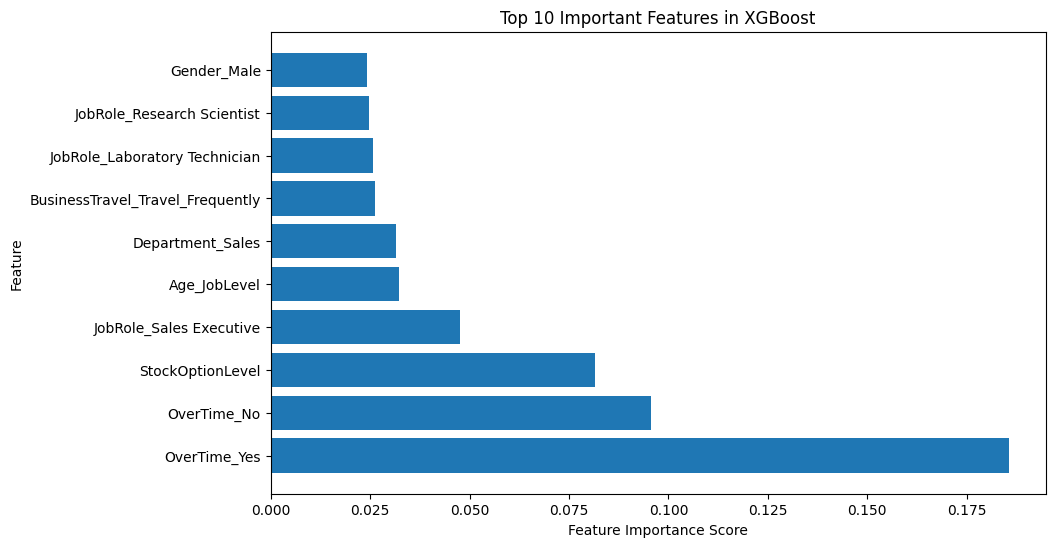

In [13]:
import matplotlib.pyplot as plt

# Get feature importances
feature_importance = model_xgb.feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1]

# Plot Top Features
plt.figure(figsize=(10, 6))
plt.barh(np.array(x_train.columns)[sorted_idx[:10]], feature_importance[sorted_idx[:10]])
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.title("Top 10 Important Features in XGBoost")
plt.show()

In [ ]:
#light Gradient Boosting
import lightgbm as lgb

# Initialize LightGBM
best_model= lgb.LGBMClassifier(
    random_state=42,
    n_estimators=500,
    learning_rate=0.2,
    max_depth=5,
    class_weight='balanced'  # Automatically handles imbalance
)

# Train Model
best_model.fit(x_train_resampled, y_train_resampled)

# Predict Probabilities
y_prob = best_model.predict_proba(x_test)[:, 1]
 #Compute precision-recall curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)

# Adjust array lengths (thresholds is always one element shorter)
precisions, recalls = precisions[:-1], recalls[:-1]

# Compute F1-score for each threshold
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)  # Avoid division by zero

# Iterate over multiple thresholds
best_f1 = 0
best_threshold = 0
for t in np.linspace(0.05, 0.3, 100):  # Test different threshold values
    y_pred_adj = (y_prob >= t).astype(int)
    f1 = f1_score(y_test, y_pred_adj)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

# Compute ROC-AUC
roc_auc = roc_auc_score(y_test, y_prob)

# Apply Adjusted Threshold
y_pred_adjusted = (y_prob >= best_threshold).astype(int)

print("Balanced Classification Report:\n", classification_report(y_test, y_pred_adjusted))
print("Balanced ROC-AUC Score:", roc_auc)
print("Balanced Threshold Found:", best_threshold)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 977, number of negative: 977
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000643 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7002
[LightGBM] [Info] Number of data points in the train set: 1954, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

In [16]:
import pickle

with open("best_lgb_model.pkl", "wb") as file:
    pickle.dump(best_model, file)